## Fonction to Raster
Prend en entrée une Satellite Image, un dossier et un nom et la sauve en JP2 dans le dossier considéré

In [ ]:
! pip install pyarrow -q -q -q 
! pip install rasterio -q -q -q 
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install albumentations -q -q -q
! pip install pytorch_lightning -q -q -q
!pip install mlflow -q -q -q

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from utils.satellite_image import SatelliteImage
from utils.utils import *
from utils.plot_utils import *

import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
#import cv2
from PIL import Image as im

from datetime import date
import re
import pyproj
import os
from tqdm import tqdm
from utils.labeler import RILLabeler
from utils.filter import is_too_black

In [2]:
root_path = get_root_path()
root_path

PosixPath('/home/onyxia/work/detection-habitat-spontane/notebooks/..')

In [3]:
update_storage_access()
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"][2022]["guyane"])

path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = os.path.join(root_path,environment["local-path"]["PLEIADES"][2022]["martinique"])

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})


In [27]:
path_s3_pleiades_data_2020_mayotte = environment["sources"]["PLEIADES"][2020]["mayotte"]
path_local_pleiades_data_2020_mayotte = os.path.join(root_path,environment["local-path"]["PLEIADES"][2020]["mayotte"])
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2020_mayotte}",
        lpath=f"{path_local_pleiades_data_2020_mayotte}",
        recursive=True)

In [ ]:
fs.download(
        rpath=f"{bucket}/{path_s3_cayenne_data}",
        lpath=f"{path_local_cayenne_data}",
        recursive=True)

In [22]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [4]:
def to_raster(satellite_image,directory_name,file_name):
    """
    save a SatelliteImage Object into a raster file (.tif)

    Args:
        satellite_image: a SatelliteImage object representing the input image to be saved as a raster file.
        directory_name: a string representing the name of the directory where the output file should be saved.
        file_name: a string representing the name of the output file.
    """

    data = satellite_image.array
    crs  = satellite_image.crs
    transform = satellite_image.transform
    n_bands = satellite_image.n_bands

    metadata = {
        'dtype': data.dtype,
        'count': n_bands,
        'width': data.shape[2],
        'height': data.shape[1],
        'crs': crs,
        'transform': transform
    }
    
    #print(os.path.exists(directory_name))
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Save the array as a raster file in jp2 format
    with rasterio.open(directory_name + "/" + file_name, 'w', **metadata) as dst:
        dst.write(data, indexes = np.arange(n_bands)+1)


def write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands, dep):
    
    """
    write the couple images mask into a specific folder

    Args:
        file_path: a string representing the path to the directory containing the input image files.
        output_directory_name: a string representing the name of the output directory where the split images and masks should be saved.
        labeler: a Labeler object representing the labeler used to create segmentation labels.
        tile_size: an integer representing the size of the tiles to split the input image into.
        n_bands: an integer representing the number of bands in the input image.
        dep: a string representing the department of the input image, or None if not applicable.
    """
    
    output_images_path  = output_directory_name + "/images"
    output_masks_path  = output_directory_name + "/labels"
    
    if not os.path.exists(output_masks_path):
        os.makedirs(output_masks_path)
        
    if not os.path.exists(output_images_path):
        os.makedirs(output_images_path)
        
    list_name = os.listdir(file_path)
    list_path = [file_path + "/" + name for name in list_name]
    
    for path, file_name in zip(list_path,tqdm(list_name)): # tqdm ici 

        big_satellite_image = SatelliteImage.from_raster(
            file_path = path,
            dep = None,
            date = None,
            n_bands= 3
        )

        list_satellite_image = big_satellite_image.split(tile_size)
        list_satellite_image = [im for im in list_satellite_image if not is_too_black(im)]
        # mettre le filtre is too black ici !!!
        for i, satellite_image in enumerate(list_satellite_image):
                
                mask = labeler.create_segmentation_label(satellite_image) 
                file_name_i = file_name.split(".")[0]+"_"+str(i)
                if(np.sum(mask) == 0): # je dégage les masques vides j'écris pasd
                    continue
                to_raster(satellite_image,output_images_path,file_name_i + ".tif")
                np.save(output_masks_path+"/"+file_name_i+".npy",mask) # save


### Test sur une image

In [7]:
satellite_image = SatelliteImage.from_raster(
        file_path = f"{path_local_pleiades_data_2022_martinique}"+ "/ORT_2022_0696_1630_U20N_8Bits.jp2",
        dep = None,
        date = None,
        n_bands= 3)

print(satellite_image.array.shape)
i = 2
directory_name = "../bibi"
file_name = "ORT_2022072050325085_0352_0545_U22N_16Bits"+"_"+str(i)+".tif"

to_raster(satellite_image,directory_name,file_name)


(3, 2000, 2000)


## Test sur l'ensemble des images

- je prends un répertoire en entrée Par exemple Guyane et je lis je split et réécris les images en taille 250
- compter le nombre d'images à traiter et le nombre d'images à l'arrivée.
- Si plusieurs années dispo généraliser le labeller 

In [26]:
# params 
file_path = f"{path_local_pleiades_data_2022_martinique}"
tile_size = 250
n_bands = 3
dep ="972"

date = datetime.strptime("20220101",'%Y%m%d')
print(date)
labeler = RILLabeler(date, dep = dep, buffer_size = 10) 
output_directory_name = "../splitted_data2"

write_splitted_images_masks(file_path,output_directory_name,labeler,tile_size,n_bands,dep)

# 1 min pour 250 -> 4min pour 1000, ça se tente un peu lionguet mais 

2022-01-01 00:00:00


100%|█████████▉| 1425/1426 [21:34<00:00,  1.10it/s]


In [28]:
len(os.listdir(output_directory_name+"/labels"))
len(os.listdir(output_directory_name+"/images"))

7969

- a priori si je connais le file path : je connais la date et je connais le labeller => créer labeller en amont ?
- On crée un labeller par date et par territoire concerné 
- On créé les masques et on les sauvegarde

 ### Train un modèle de segmentation Réadaptation de la classe DeeplaV3module pour la rendre agnostique  au dataset etc..

In [5]:
#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload
import sys
sys.path.append('../src')
import utils.utils
import sys
import os

import pytorch_lightning as pl
import torch
import gc
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

## from src
from datas.components.dataset import PleiadeDataset, ChangeDetectionS2LookingDataset
from models.components.segmentation_models import DeepLabv3Module
from models.segmentation_module import SegmentationModule
from datas.datamodule import DataModule


In [6]:
update_storage_access()
#%env AWS_ACCESS_KEY_ID=projet-slums-sa
#%env AWS_SECRET_ACCESS_KEY=hB2N6hCmp7JoFA6WHKT022WJ9lOc1oOr # chercher ça dans secret ? normalement le update storage access suffit
#%env AWS_S3_ENDPOINT=minio.lab.sspcloud.fr
%env MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr
# à préciser en +

env: MLFLOW_S3_ENDPOINT_URL=https://minio.lab.sspcloud.fr


In [ ]:
satellite_image = SatelliteImage.from_raster(
        #file_path = "../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0691_1638_U20N_8Bits.jp2",
        file_path ="../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2", # 255 couleurs..
        dep = None,
        date = None,
        n_bands= 3)
satellite_image.plot([0,1,2])

In [7]:

## Création Dataset
torch.cuda.empty_cache()
gc.collect()

dir_data = "../splitted_data2"
list_path_labels =  np.sort([dir_data + "/labels/" + name for name in os.listdir(dir_data+"/labels")])# os.wlk dans d'autres cas sous des sous arbres de S2Looking
list_path_images =  np.sort([dir_data + "/images/" + name for name in os.listdir(dir_data+"/images")])
dataset = PleiadeDataset(list_path_images,list_path_labels)

# liste d'images test à tester 
satellite_image = SatelliteImage.from_raster(
        file_path = "../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0519_8586_U38S_8Bits.jp2",
        #file_path =  "../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2",
    # "../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0691_1638_U20N_8Bits.jp2",
        dep = None,
        date = None,
        n_bands= 3) # ../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0524_8590_U38S_8Bits.jp2 fonctions d'affichage de Raya

list_test = satellite_image.split(250)
directory_image_name = "../test_data/images/"

for i,simg in enumerate(list_test):
    file_name = simg.filename.split(".")[0] +"_"+str(i)+".tif"
    to_raster(simg,directory_image_name,file_name)

list_path_images_test = np.sort([directory_image_name + filename for filename in os.listdir(directory_image_name)])
list_path_labels_test =   np.sort(list_path_labels[:len(list_path_images_test)])# pas propre je metsd une liste de labels de même taille inutilisés

dataset_test = PleiadeDataset(list_path_images_test,list_path_labels_test) 

# à changer avec des images bien spécifiques et une fonction préparer test
# faire un mini batch qui ne contient que les patchs d'uune image d'intérêt créer les fichiers iages en local et les utiliser pour reconstituer une full image !
# print(list_path_images_test)

## Transforms à mettre dans le data module
image_size = (250,250)
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)



## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module()



##Instanciation des datamodule et plmodule


data_module = DataModule(
    dataset= dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=9,
    dataset_test = dataset_test
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)



checkpoint_callback = ModelCheckpoint(
    monitor="validation_IOU", save_top_k=1, save_last=True, mode="max"
)

early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"
list_callbacks = [lr_monitor, checkpoint_callback, early_stop_callback]


In [8]:
#!pip install mlflow
import mlflow
mlflow.end_run()

run_name = "modele deeplabV39"
remote_server_uri = "https://projet-slums-detection-386760.user.lab.sspcloud.fr"
experiment_name = "segmentation"


mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()



with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks= list_callbacks,
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)


2023/04/16 11:49:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
2023/04/16 11:49:44 WARNING mlflow.utils.autologgin

Sanity Checking: 0it [00:00, ?it/s]

/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the 

Training: 0it [00:00, ?it/s]

/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Test du modèle

2023/04/17 11:03:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2023/04/17 11:03:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgo6ke4gt/model/data, flavor: pytorch), fall back to return ['torch==2.0.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
parametrer le numero du. batch en fonction de la taille du batch et dunb d'elements dans tests..
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
───────────────────────────────────────────────────────────

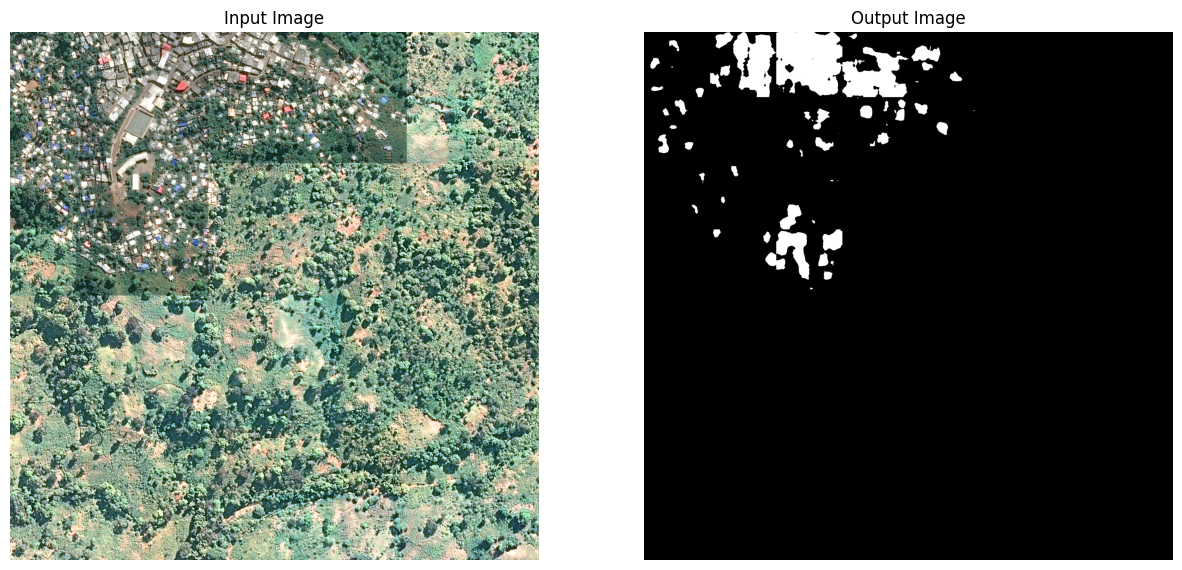

In [9]:
#trainer.checkpoint_callback.best_model_path
import mlflow
mlflow.end_run()

run_name = "modele deeplabV38"
remote_server_uri = "https://projet-slums-detection-386760.user.lab.sspcloud.fr"
experiment_name = "segmentation"

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()

output_ligthning = 'lightning_logs/'

with mlflow.start_run(run_id="0c7742ac29844f95ab49b05dc9c4842f"):
    model = DeepLabv3Module()
    
    lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=output_ligthning+'version_12/checkpoints/epoch=34-step=24815.ckpt',
    model= model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                         )
    #artifact_path = "modele_segmentation_deeplabv3"
    #mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)

    trainer = pl.Trainer(
    callbacks= list_callbacks,
    max_epochs=50,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.test(lightning_module_checkpoint, datamodule=data_module)


In [77]:
find_image_of_point(coordinate, "../data/PLEIADES/2020/MAYOTTE/", coord_gps = True) 

'../data/PLEIADES/2020/MAYOTTE//ORT_2020052526670967_0519_8586_U38S_8Bits.jp2'

In [ ]:
idx =35
SatelliteImage.from_raster(
        #file_path =  "../data/PLEIADES/2020/MAYOTTE/" +os.listdir("../data/PLEIADES/2020/MAYOTTE")[idx],
        file_path = "../data/PLEIADES/2020/MAYOTTE/ORT_2020052526670967_0519_8586_U38S_8Bits.jp2",
        dep = None,
        date = None,
        n_bands= 3).plot([0,1,2])




# faire une fonction !!
- Ici j'évalue un batch à la mano

In [ ]:

def evaluate_quick(datasetparam,model,idx):
    imagesat = SatelliteImage.from_raster(datasetparam.list_paths_images[idx],"976",n_bands = 3) 

    model.eval()
    model = model.to("cuda")
    #image, mask, dic = dataset_test[idx]
    image, mask, dic = datasetparam[idx]

    # mask réel
    plt.imshow(mask, cmap='binary', interpolation='none')
    plt.colorbar(ticks=[0, 1])
    plt.show()

    # image
    imagesat.plot([0,1,2])

    # model
    output = model(image.unsqueeze(0).to("cuda"))
    print(output.shape)
    mask_model = np.array(torch.argmax(output,axis= 1).squeeze(0).to("cpu"))
    print(np.sum(mask_model))
    # mask model
    plt.imshow(mask_model, cmap='binary', interpolation='none')
    plt.colorbar(ticks=[0, 1])
    plt.show()


In [ ]:
mask_model

In [ ]:

model = lightning_module_checkpoint.model
#evaluate_quick(dataset,model,23)
evaluate_quick(dataset,model,70)
evaluate_quick(dataset_test,model,49)

- marrant de voir comment la normalisation detecte les logements..sérendipité
- qgis

## Petite enquête pour savoir pourquoi les résultats sont éclatés sur l'exmple de Mayotte

In [ ]:
idx = 2

for idx in range(64):
    imagesat = SatelliteImage.from_raster(dataset_test.list_paths_images[idx],"976",n_bands = 3) 
    print(torch.max(dataset_test[idx][0]))
    np.max(imagesat.array)
    
for idx in range(64):
    imagesat = SatelliteImage.from_raster(dataset.list_paths_images[idx],"976",n_bands = 3) 
    print(torch.max(dataset[idx][0]))
    np.max(imagesat.array)
np.max(satellite_image.array)

Il y a déjà une normalisation entre 0 et 255 appliqué&e sur mayotte ça peut forcément pas marcher..

## gestion MLFlow

In [36]:
from mlflow import MlflowClient
run = mlflow.get_run(run_id="0c7742ac29844f95ab49b05dc9c4842f")
#r.data.tags.items() if not k.startswith("mlflow.")}
artifacts = [f.path for f in MlflowClient().list_artifacts(run.info.run_id, "plots")]
#print_auto_logged_info()
artifacts

['plots/image_test.png']

In [37]:
#  MlflowClient().list_artifacts(run.info.run_id) ok pour lister les sous dossiers
MlflowClient().list_artifacts(run.info.run_id)
artifacts = [f.path for f in MlflowClient().list_artifacts(run.info.run_id, "plots")]
artifacts[0]

'plots/image_test.png'

In [38]:
print("run_id: {}".format(run.info.run_id))
print("params: {}".format(run.data.params))
print("metrics: {}".format(run.data.metrics))

path = mlflow.artifacts.download_artifacts(run_id = run.info.run_id)


run_id: 0c7742ac29844f95ab49b05dc9c4842f
params: {'monitor': 'validation_loss', 'mode': 'min', 'patience': '3', 'min_delta': '-0.0', 'stopped_epoch': '0', 'epochs': '100', 'optimizer_name': 'SGD', 'lr': '0.0001', 'momentum': '0.9', 'dampening': '0', 'weight_decay': '0', 'nesterov': 'False', 'maximize': 'False', 'foreach': 'None', 'differentiable': 'False'}
metrics: {'train_loss': 0.24770013988018036, 'train_loss_epoch': 0.24770013988018036, 'train_loss_step': 0.28203338384628296, 'validation_IOU': 0.49895596504211426, 'validation_loss': 0.2548619508743286, 'stopped_epoch': 34.0, 'restored_epoch': 31.0, 'best_score': 0.2544165551662445, 'wait_count': 3.0}


In [40]:
path # c'est le ^path où  sont téléchargés les artefacts en local

'/tmp/tmpf90n2ev1/'

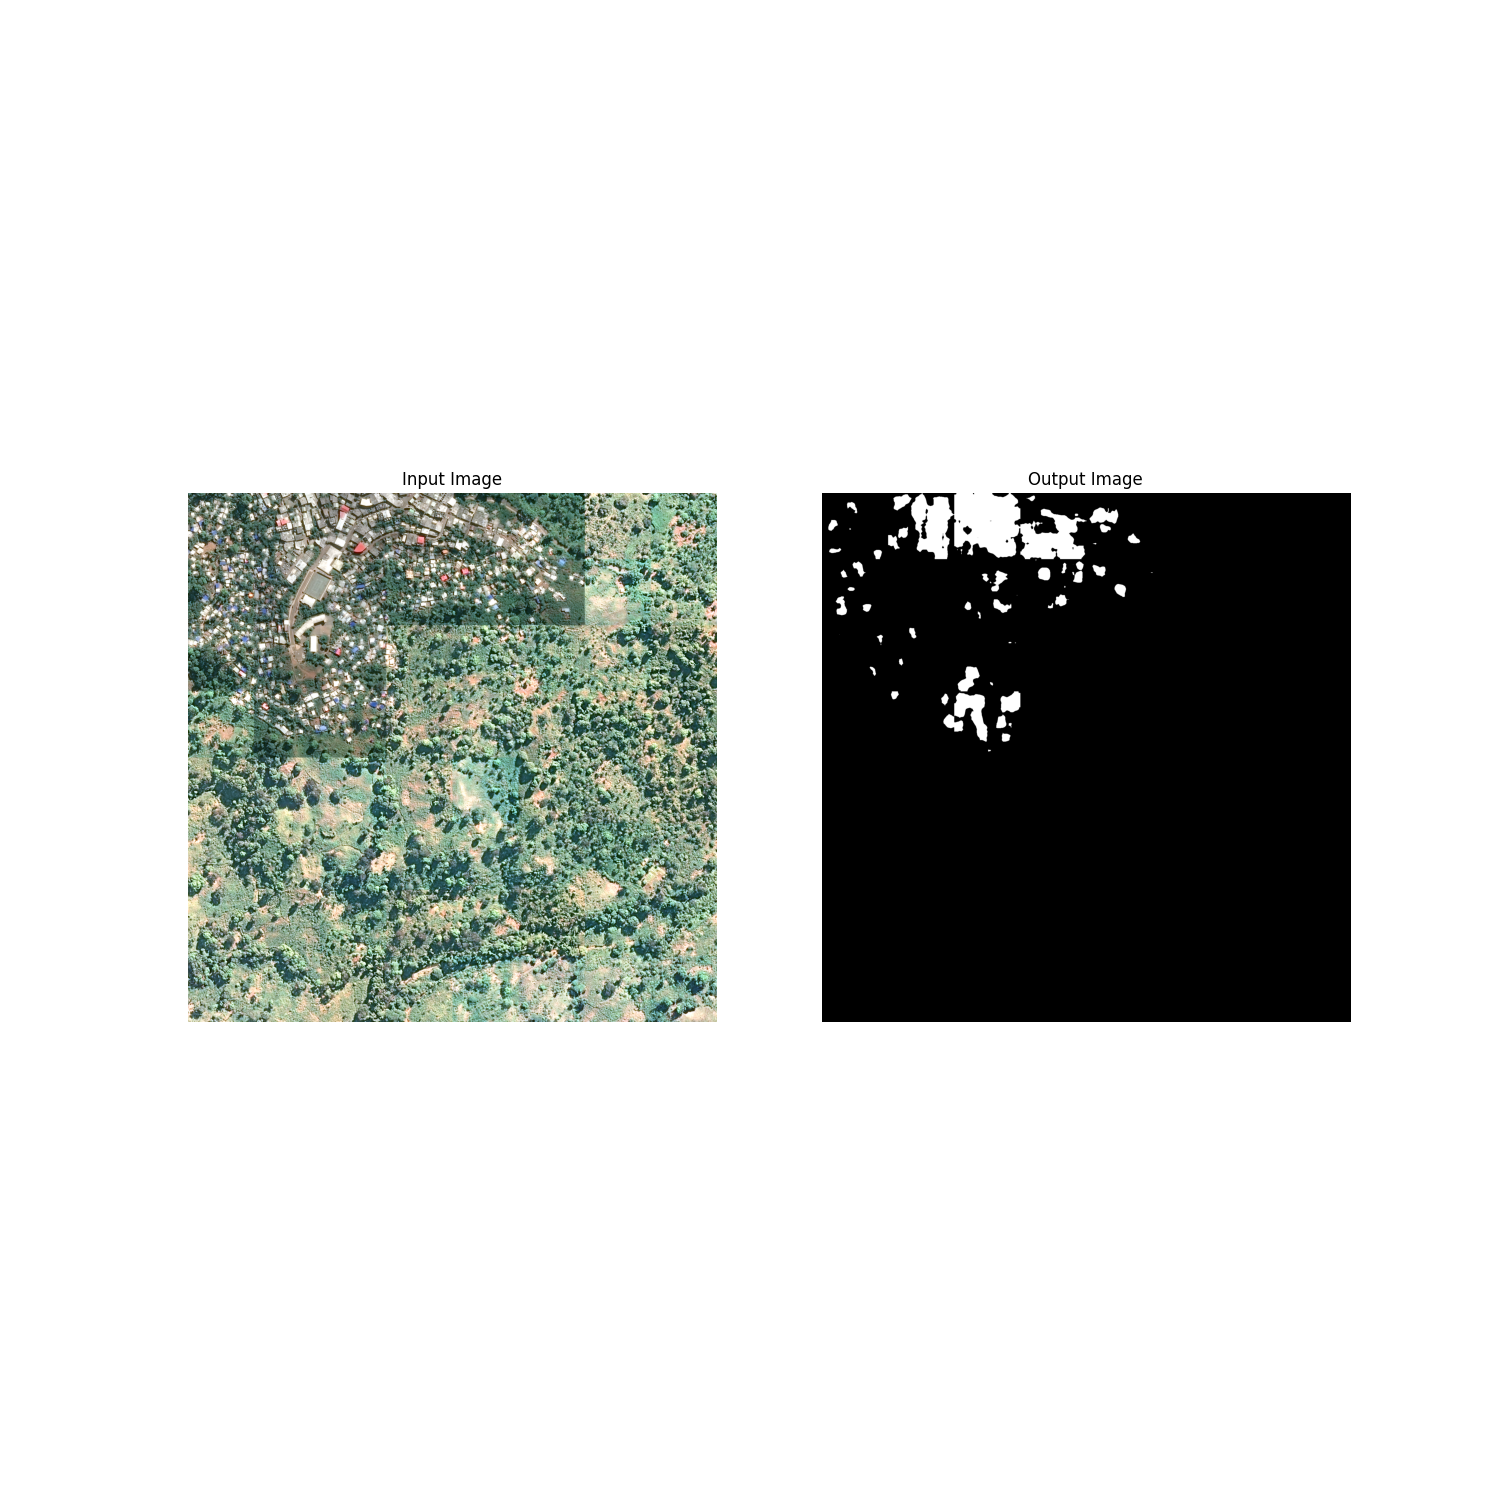

In [42]:
from PIL import Image
os.listdir(path+"plots/")
im = Image.open(path+"plots/image_test.png")
im.show()

**Save with pytorch**

In [26]:
import mlflow.pytorch

# Log PyTorch model
with mlflow.start_run() as run:
    mlflow.pytorch.log_model(model, "model")

2023/04/17 11:17:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7aw4dlgq/model/data, flavor: pytorch), fall back to return ['torch==2.0.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


TO DO :
- les images Guyane sont en 16 bits et MAyotte et martinique etc.. en 8 normal que ça deconne
- faire en sorte de calculer plusieurs grosse images sur le .test et trouver une autre image que mayotte pour le moment qui est en 255 couleurs... != du reste
- mettre une oimage de la validation en jeu
- mettre le calcul d'image dans la validation aussi ?
- mettre dans data set test une image du jeu de validatio à minima et une image de jeu externe etc..
- dégager aussi les RIL vides ? Oui
- labelstudio, segment anything model
- bien construire un beau jeu de test avec cet outil  label studio, labellisation à la main , pour evaluation pertinente !!
- mettre le [0,1,2] par défautdans les plots
- se servir du if batch idx == 10 recharger tout les fichiers des batchs précédents et en faire une satellite data, stocker également ce qui fera une seule image et donc une seule labelled satellite image ..
- dans le filename des images splittée changer avec les bonnes coordonnées dans lenom (trouvable dans la bounding box..)
- faire une fonction générer dataset test qui servira pour tous les tests
- test de lancement via invit de comande train
- généraliser la création de liste de file path selon le dataset souhaité
- créer un yaml de config et le logger dans mlflow
- contrîole sur le modèle qui est loggé dans ml flow ?
- resoudre le bug sur l'ambiguité du nombre d'elemeents dans le batch
- workshop fevrier

Reunion section
- 13 travaux
- Production de masques : Juin Juillet,
    - Esane normal + Branches
    - demographie  # RDV Nathanael + soutien code
    - maj EAP (Optionnel)
    - IPI ICA
    - Antipol, tab multi
    
rtauargus prez , veux-tu présenter ? nathanael ?
fideli ..
pour rtauargus mix des différentes présentations déjà faites :
que veux-on partager, pas NTTIS
différentes prez du worksho en Septembre dernier exemples bien senti

Présentation "paillettes" -> d'où vient la complexité des données ? décrire avec le graph
tau argus outil de référence, différnets types de complexité , une partie résolu liens tableaux, partie non résolue, partie analyse de la demande, + méta données non automatisées
-> rtauargus
-> 
-> création liste de tables c'est sympa ça demande une généralisation, une métadonnées nickel permettrait d'automatiser cette analyse
-> insee.fr exemple, overlezf, reprise présentation

- census bureau litterature reunion Julien

## S2Looking training !

dl

In [ ]:
update_storage_access()
environment = get_environment()
root_path = get_root_path()
bucket = environment["bucket"]
path_s3_s2looking = environment["sources"]["PAPERS"]["S2Looking"]
path_local_s2looking = environment["local-path"]["PAPERS"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

fs.download(
        rpath=f"{bucket}/{path_s3_s2looking}",
        lpath=f"../{path_local_s2looking}",
        recursive=True)

In [ ]:
import zipfile
with zipfile.ZipFile(f"../{path_local_s2looking}/S2Looking.zip", 'r') as zip_ref:
    zip_ref.extractall(f"../{path_local_s2looking}")

In [ ]:
#!pip install mlflow
import mlflow

run_name = "s2looking" # config
remote_server_uri = "https://projet-slums-detection-2439.user.lab.sspcloud.fr"
experiment_name = "segmentation" # config

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)
# mlflow.pytorch.autolog() # logger la config


## Création Dataset
torch.cuda.empty_cache()
gc.collect()

## En faire une fonction ? : Idée faire une classe de préparation des données pour chaque data set chargé qui in fine sortirait une list path ?

### config, appeler une fionction de création de dataset ?
dir_data = "../data/paper_dataset/S2Looking/"
img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]

img1_train = [dir_data + "train/Image1/"+name for name in os.listdir(dir_data + "/train/Image1")]
img1_val = [dir_data + "val/Image1/"+name for name in os.listdir(dir_data + "/val/Image1")]
img1_test = [dir_data + "test/Image1/"+name for name in os.listdir(dir_data + "/test/Image1")]

img2_train = [dir_data + "train/Image2/"+name for name in os.listdir(dir_data + "/train/Image2")]
img2_val = [dir_data + "val/Image2/"+name for name in os.listdir(dir_data + "/val/Image2")]
img2_test = [dir_data + "test/Image2/"+name for name in os.listdir(dir_data + "/test/Image2")]

label_train = [dir_data + "train/label/"+name for name in os.listdir(dir_data + "/train/label")]
label_val = [dir_data + "val/label/"+name for name in os.listdir(dir_data + "/val/label")]
label_test = [dir_data + "test/label/"+name for name in os.listdir(dir_data + "/test/label")]

img1_path = np.concatenate([np.sort(img1_train),np.sort(img1_val),np.sort(img1_test)])
img2_path = np.concatenate([np.sort(img2_train),np.sort(img2_val),np.sort(img2_test)])
label_path = np.concatenate([np.sort(label_train),np.sort(label_val),np.sort(label_test)])

mono_image_dataset = ChangeDetectionS2LookingDataset(img1_path,img2_path,label_path)

# transforms incorporé dans les dataset a posteriori
image_size = (256,256) # cf la classe dataset
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ]
    )

transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ]
)


## Instanciation modèle et paramètres d'entraînement

optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module(nchannel = 6) # viens du data set qui concatene 2 images à 3 channels

##Instanciation des datamodule et plmodule

data_module = DataModule(
    mono_image_dataset= mono_image_dataset,
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, 
    batch_size=2
)


lightning_module = SegmentationModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)

checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)

checkpoint_callback_2 = ModelCheckpoint(
    monitor="train_loss", save_top_k=1, save_last=True, mode="min"
)
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

strategy ="auto"

with mlflow.start_run(run_name=run_name):

    trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback,checkpoint_callback_2, early_stop_callback],
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
    )
    trainer.fit(lightning_module, datamodule=data_module)
    
    lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )
    artifact_path = "models/modele_change_detection_deeplabv3_on_s2_looking"
    mlflow.pytorch.log_model(lightning_module_checkpoint.model, artifact_path)
    
    